# Research Question

Predict which publisher's books are more likely to receive higher ratings.

These insights are intended to help managers of the bookstore decide which kinds of books they should buy (and not buy) in the future for best sales, and which books they should recommend to buyers as possible additional purchases. The outcomes of your analysis will be communicated through both a presentation and a written technical report targeted towards a managerial audience.

# Pre-Processing

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [277]:
books = pd.read_csv('BX-Books.csv')
ratings = pd.read_csv('BX-Ratings.csv')
users = pd.read_csv('BX-Users.csv')

In [278]:
# Check data types
print(books.dtypes)
books.head()

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Book-Publisher         object
dtype: object


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
3,0440234743,The Testament,John Grisham,1999,Dell
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume


In [279]:
print(ratings.dtypes)
ratings.head()

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


,User-ID,ISBN,Book-Rating
0,276744,038550120X,7
1,276754,0684867621,8
2,276755,0451166892,5
3,276762,0380711524,5
4,276772,0553572369,7


In [280]:
print(users.dtypes)
users.head() # Missing value!

User-ID          int64
User-City       object
User-State      object
User-Country    object
User-Age        object
dtype: object


,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",NaN
1,9,germantown,tennessee,"usa""",NaN
2,16,albuquerque,new mexico,"usa""",NaN
3,17,chesapeake,virginia,"usa""",NaN
4,19,weston,,NaN,"14"""


## Check Missing Value

In [281]:
# books
missing_values = books.isna().sum()
# print missing value for each column
display(missing_values)

# ratings
missing_values = ratings.isna().sum()
# print missing value for each column
display(missing_values)

# users
missing_values = users.isna().sum()
# print missing value for each column
display(missing_values)

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64

## Deal with missing value (User Dataset)

In [282]:
print("# of Cities: ", len(set(users['User-City']))) # Too many missing values, hard to imput
print("# of States: ", len(set(users['User-State'])))
print("# of countries: ", len(set(users['User-Country'])))

# of Cities:  9545
# of States:  1087
# of countries:  189


### Impute missing countries

In [283]:
# Clean country name
users['User-Country'] = users['User-Country'].str.replace('"', '').str.strip().str.lower().replace('', pd.NA)

In [284]:
# State -> VIC, Country -> AU
# State -> VIC, Country -> ?   Check State, imput country

# Check for missing countries and state/city combination
missing_countries = users[users['User-Country'].isnull()]
existing_data = users.dropna(subset=['User-Country'])

# Create a dictionary mapping states to countries
state_to_country_map = existing_data.groupby('User-State')['User-Country'].first().to_dict()

# Impute missing countries based on the state
for index, row in missing_countries.iterrows():
    state = row['User-State']
    if state in state_to_country_map:
        users.at[index, 'User-Country'] = state_to_country_map[state]

In [285]:
#users, still have two counyries lefy
missing_values = users.isna().sum()
print(missing_values)

User-ID             0
User-City          61
User-State          0
User-Country        2
User-Age        18952
dtype: int64


In [286]:
#users.dropna(subset=['User-Country'], inplace=True)

In [287]:
country_frequency = users['User-Country'].value_counts()
country_frequency

User-Country
usa               35044
canada             4629
germany            1872
united kingdom     1784
australia           984
                  ...  
burma                 1
worcester             1
america               1
aroostook             1
ghana                 1
Name: count, Length: 188, dtype: int64

In [288]:
# identify countries with count less than 1000, not representable
country_frequency = users['User-Country'].value_counts()
countries_to_replace = country_frequency[country_frequency < 1000].index

# Replace these countries with 'others' in the users Dataframe
#users.loc[users['User-Country'].isin(countries_to_replace)]['User-Country'] = 'others'
users.loc[users['User-Country'].isin(countries_to_replace),'User-Country'] = 'others'

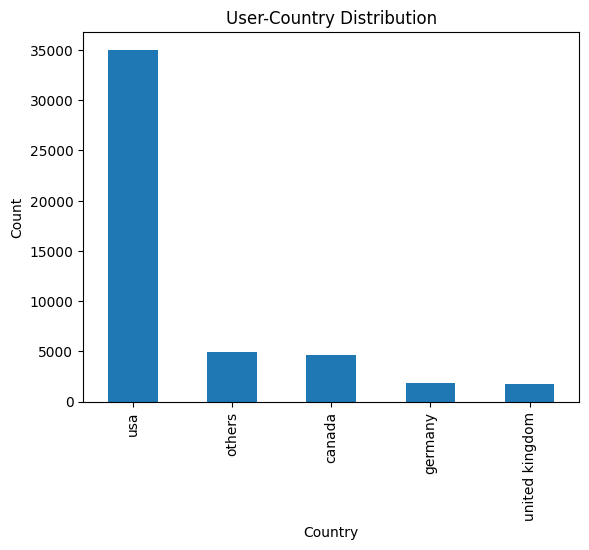

In [289]:
# Plot the bar chat
users['User-Country'].value_counts().plot(kind='bar')

# Set Plot title and labels
plt.title('User-Country Distribution')
plt.xlabel('Country')
plt.ylabel('Count')

plt.show()

### Age

In [290]:
# Replace ", and value type
users['User-Age'] = users['User-Age'].str.replace('"', '').replace('NaN', pd.NA).astype('Int64')
print(users['User-Age'])

0        <NA>
1        <NA>
2        <NA>
3        <NA>
4          14
         ... 
48294      23
48295      23
48296      33
48297      32
48298    <NA>
Name: User-Age, Length: 48299, dtype: Int64


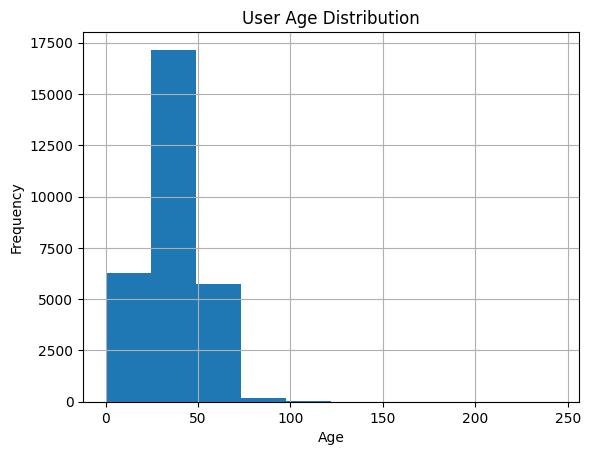

In [291]:
users['User-Age'].hist(bins=10)

# Set Plot title and labels
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Display the plot
plt.show()

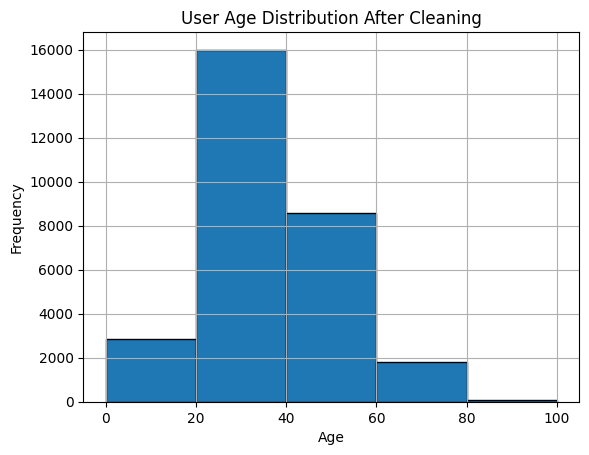

In [292]:
# Change noisy data, some user may not reveal real age
# Use .clip(): assigns values outside boundary to boundary values. 

users['User-Age'] = users['User-Age'].clip(upper=100)
users['User-Age'].hist(bins=5, edgecolor='Black')

# Set Plot title and labels
plt.title('User Age Distribution After Cleaning')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Display the plot
plt.show()

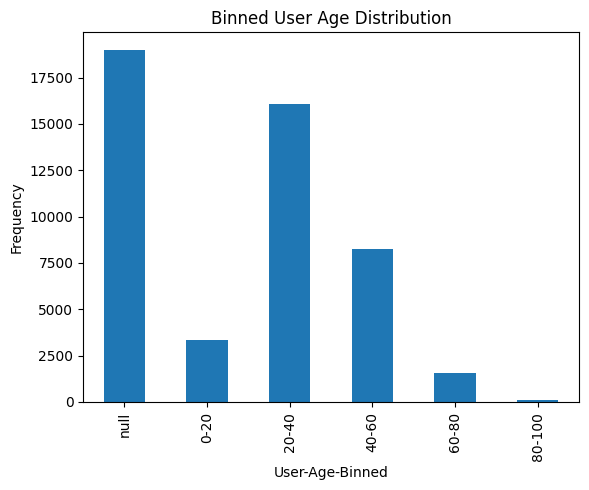

In [293]:
# Change age into categorical variable
bins = [-float('inf'), 0, 20, 40, 60, 80, 100]
#bins = [0, 20, 40, 60, 80, 100]
labels = ['null', '0-20', '20-40', '40-60', '60-80', '80-100']
#labels = [0, 1, 2, 3, 4]

users['User-Age'].fillna(-1, inplace=True) # Fill in NaN values, as a sigle label.

# Bin User-Age values
users['User-Age-Binned'] = pd.cut(users['User-Age'], bins=bins, labels=labels, include_lowest=True)

# Plot histogram for binned User-Age
users['User-Age-Binned'].value_counts().sort_index().plot(kind='bar')

# Set Plot title and labels
plt.title('Binned User Age Distribution')
plt.ylabel('Frequency')

# Display the plot
plt.show()

There is a large percentage of readers who do not provide age, and young adults (20-40) make up the majority of ratings

### User-City

In [294]:
# Remove City that we don't need
users.drop(['User-City'], axis=1, inplace=True)

### User-State

In [295]:
users.groupby('User-Country')['User-State'].value_counts()

User-Country  User-State       
canada         ontario             1804
               british columbia    1225
               alberta              629
               quebec               215
               nova scotia          214
                                   ... 
usa            c.t                    1
               calfiornia             1
               callif                 1
               cascadia               1
               co                     1
Name: count, Length: 1223, dtype: int64

In [296]:
# Get top five states for each country，set the rest state as others
top_states = users.groupby('User-Country')['User-State'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)
#top_states_list = top_states.index.get_level_values(1).tolist()

top_states_dic = {}
for country in top_states.index.get_level_values(0).unique():
    top_states_dic[country] = top_states.loc[country].index.tolist()[:5]

# Display the dictionary
print(top_states_dic)

{'canada': [' ontario', ' british columbia', ' alberta', ' quebec', ' nova scotia'], 'germany': [' nordrhein-westfalen', ' bayern', ' baden-wuerttemberg', ' hessen', ' niedersachsen'], 'others': [' n/a', ' new south wales', ' victoria', ' queensland', ' madrid'], 'united kingdom': [' england', ' scotland', ' n/a', ' wales', ' london'], 'usa': [' california', ' texas', ' new york', ' florida', ' washington']}


In [297]:
for index, row in users.iterrows():
    country = row['User-Country']
    state = row['User-State']

    # Check if User-Country is in the top_states_dic keys
    if country in top_states_dic:
        # Check if the User-State is in the top_states_dic values(top 5 states)
        if state not in top_states_dic[country]:
            # Change User-State to "Others" (Set value at specified row/column pair by using .at())
            users.at[index, 'User-State'] = 'others'

    # Set states of 'Other' country
    #if country == 'others':
    #   users.at[index, 'User-State'] = 'others'

# Display the updated users DataFrame
print(users)

       User-ID   User-State User-Country  User-Age User-Age-Binned
0            8      ontario       canada        -1            null
1            9       others          usa        -1            null
2           16       others          usa        -1            null
3           17       others          usa        -1            null
4           19       others          usa        14            0-20
...        ...          ...          ...       ...             ...
48294   278846      ontario       canada        23           20-40
48295   278849      ontario       canada        23           20-40
48296   278851        texas          usa        33           20-40
48297   278852   queensland       others        32           20-40
48298   278854       others          usa        -1            null

[48299 rows x 5 columns]


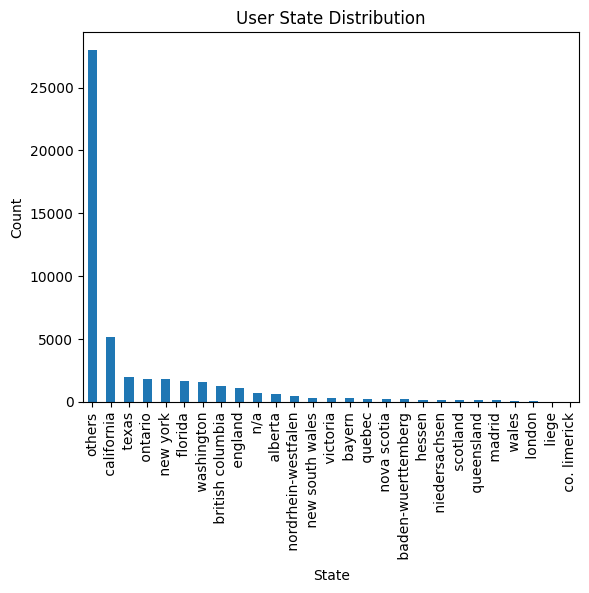

In [298]:
# Plot the bar chat
users['User-State'].value_counts().plot(kind='bar')

# Set Plot title and labels
plt.title('User State Distribution')
plt.xlabel('State')
plt.ylabel('Count')

plt.show()

Could Drop State and country if they are not useful(if we don't change research question)

### Encoding users
change to Numerical representation /if use state and country

In [299]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

users['User-Age-Binned'] = label_encoder.fit_transform(users['User-Age-Binned'])
users['User-Country-Encoded'] = label_encoder.fit_transform(users['User-Country'])
users['User-State-Encoded'] = label_encoder.fit_transform(users['User-State'])
users

,User-ID,User-State,User-Country,User-Age,User-Age-Binned,User-Country-Encoded,User-State-Encoded
0,8,ontario,canada,-1,5,0,18
1,9,others,usa,-1,5,4,26
2,16,others,usa,-1,5,4,26
3,17,others,usa,-1,5,4,26
4,19,others,usa,14,0,4,26
...,...,...,...,...,...,...,...
48294,278846,ontario,canada,23,1,0,18
48295,278849,ontario,canada,23,1,0,18
48296,278851,texas,usa,33,1,4,22
48297,278852,queensland,others,32,1,2,20


### Finish User

In [300]:
users_cleaned = users[['User-ID', 'User-Age', 'User-Age-Binned', 'User-State-Encoded', 'User-Country-Encoded']]
users_cleaned.head()

,User-ID,User-Age,User-Age-Binned,User-State-Encoded,User-Country-Encoded
0,8,-1,5,18,0
1,9,-1,5,26,4
2,16,-1,5,26,4
3,17,-1,5,26,4
4,19,14,0,26,4


## Boook Dataset

### Year of Publication

Text(0, 0.5, 'Frequency')

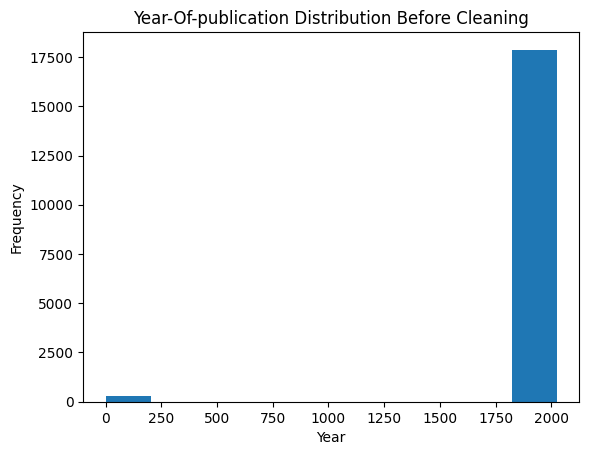

In [301]:
plt.figure()
plt.hist(books['Year-Of-Publication'].clip(upper=2024))
plt.title('Year-Of-publication Distribution Before Cleaning')
plt.xlabel('Year')
plt.ylabel('Frequency')

<Axes: >

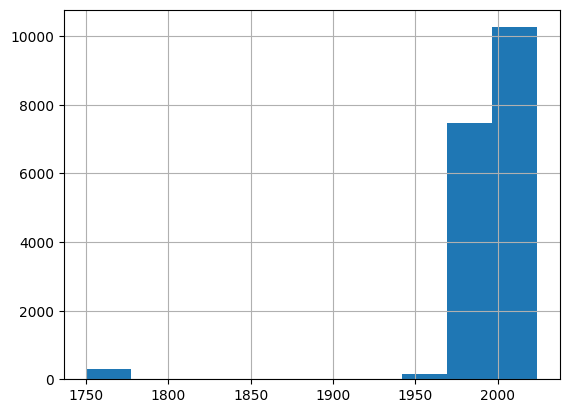

In [302]:
books['Year-Of-Publication'].clip(upper=2024, lower=1750).hist()

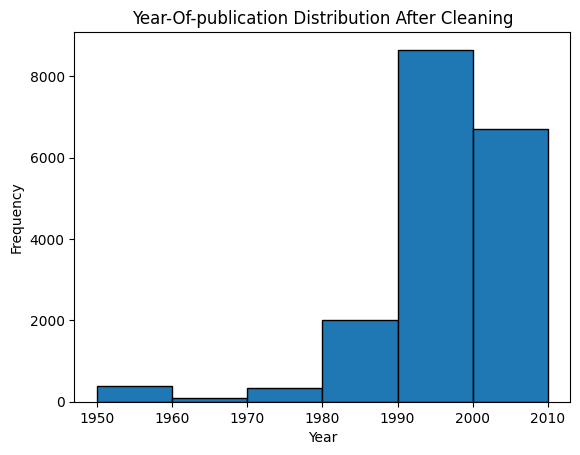

In [303]:
# Remove noisy data
books['Year-Of-Publication'] = books['Year-Of-Publication'].clip(upper=2010, lower=1950)
bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
#books['Year-Of-Publication'].hist(bins=bins, edgecolor='Black')

# Set Plot title and labels
plt.figure()
plt.hist(books['Year-Of-Publication'], bins=bins, edgecolor='Black')
plt.title('Year-Of-publication Distribution After Cleaning')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010])

# Display the plot
plt.show()

In [304]:
bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
books['Year-Of-Publication-Binned'] = pd.cut(books['Year-Of-Publication'], bins=bins, right=False)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Binned
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"[2000, 2010)"
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"[1990, 2000)"
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,"[1990, 2000)"
3,0440234743,The Testament,John Grisham,1999,Dell,"[1990, 2000)"
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,"[1990, 2000)"


### Deal with text (Auther & Publisher)

In [305]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

def preprocess_pattern(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text
books['Book-Author'] = books['Book-Author'].apply(preprocess_pattern)
books['Book-Publisher'] = books['Book-Publisher'].apply(preprocess_pattern)

books['Book-Author-Encoded'] = label_encoder.fit_transform(books['Book-Author'])
books['Book-Publisher-Encoded'] = label_encoder.fit_transform(books['Book-Publisher'])
books['Year-Of-Publication-Binned'] = label_encoder.fit_transform(books['Year-Of-Publication-Binned'])

# Display the updated bos DataFrame
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Binned,Book-Author-Encoded,Book-Publisher-Encoded
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5,5172,512
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,4,2158,398
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,4,241,940
3,0440234743,The Testament,John Grisham,1999,Dell,4,3066,285
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,4,6108,898


### Book-Title

In [306]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Casefolding
    lowercased = str(text).lower()
    # Noise (punctuation) removal
    no_punct = re.sub(r'[^A-Za-z\s]', '', lowercased)
    no_punct = re.sub(r'\s+', ' ', no_punct)
    # Tokenization
    tokens = nltk.word_tokenize(no_punct)
    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    # Lemmatise the no stopword lists
    lemmatized = [lemmatizer.lemmatize(w) for w in tokens if not w in stop_words]
    text = ' '.join(lemmatized)

    return text

books['Book-Title'] = books['Book-Title'].apply(preprocess)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Binned,Book-Author-Encoded,Book-Publisher-Encoded
0,0002005018,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5,5172,512
1,0374157065,flu story great influenza pandemic search viru...,Gina Bari Kolata,1999,Farrar Straus Giroux,4,2158,398
2,0399135782,kitchen god wife,Amy Tan,1991,Putnam Pub Group,4,241,940
3,0440234743,testament,John Grisham,1999,Dell,4,3066,285
4,0452264464,beloved plume contemporary fiction,Toni Morrison,1994,Plume,4,6108,898


### Approaches to text vector representation:

1. Bag-of-words: This approach represents each document as a vector of word frequencies, with each dimension of the vector corresponding to a different word in the vocabulary.

2. TF-IDF: This approach is similar to the bag-of-words model, but it also takes into account the importance of each word in the document corpus.

3. Word embeddings: This approach represents each word as a dense vector of real numbers, which are learned through a neural network model.

In [307]:
from sklearn.feature_extraction.text import CountVectorizer
## Note that by default CountVectorizer only considers alphanumeric patterns of at least 2 characters to be a word.  
## You can alter this behavior using the token_pattern parameter.
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(books['Book-Title'])

vocabulary = vectorizer.get_feature_names_out()
#print(len(vocabulary)) # There are 11627 interesting "words" after the preprocessing all titles!

# the BoW matrix
bow_df = pd.DataFrame(bow.toarray(), columns=vocabulary, index=books.index)

import seaborn as sns
from sklearn.decomposition import PCA

# conduct PCA with n=3 components (or axis)
pca = PCA(n_components=3)
bow_pca = pca.fit_transform(bow_df)

# a measure of how much of the total variance in the data is explained by each of these principal components
explained_var = pca.explained_variance_ratio_

#print(f"Variance explained by each PC: {explained_var}")   
print(f"Total variance explained by {len(explained_var)} components: {explained_var.sum():.4f}")

Total variance explained by 3 components: 0.0508


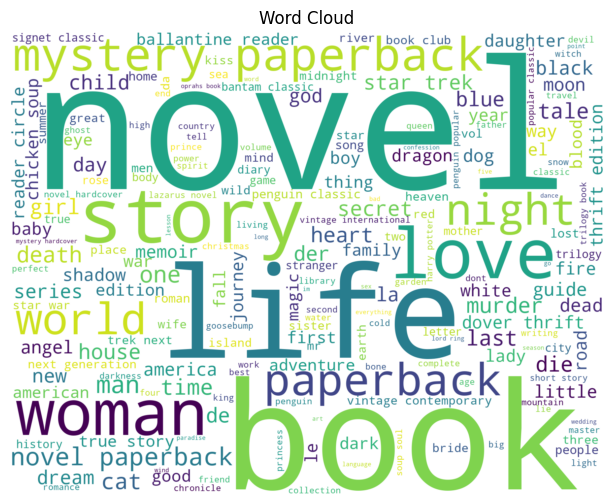

In [308]:
combined_text = books['Book-Title']

wordcloud = WordCloud(width=1800, height=1400, background_color='white').generate(' '.join(combined_text))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

### Try TF-IDF

In [309]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
# Fit and Transform Book-Title column
tfidf = vectorizer.fit_transform(books['Book-Title'])
tfidf

<18185x11981 sparse matrix of type '<class 'numpy.float64'>'
	with 63272 stored elements in Compressed Sparse Row format>

In [310]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
# Fit and Transform Book-Title column
tfidf = vectorizer.fit_transform(books['Book-Title'])

vocabulary = vectorizer.get_feature_names_out()
print(len(vocabulary)) # There are 11627 interesting "words" after the preprocessing all titles!
print(vocabulary[:50])
# Print the TF-IDF matrix

11981
['ab' 'abaddon' 'abandon' 'abandoned' 'abarat' 'abbey' 'abbotts' 'abby'
 'abc' 'abdication' 'abduction' 'abel' 'abelard' 'abendhauch' 'abenteuer'
 'aberystwyth' 'abhorsen' 'abide' 'abides' 'abiding' 'abigail' 'ability'
 'abominable' 'aborted' 'abortion' 'abraham' 'abrams' 'abrechnung'
 'abroad' 'absalom' 'abschaffung' 'absence' 'absolute' 'absolutely'
 'absurdity' 'abundance' 'abuse' 'abusive' 'abyss' 'abz' 'acaba' 'academe'
 'academy' 'acadia' 'accelerated' 'acceleration' 'accent' 'acceptable'
 'acceptance' 'access']


### Dimension deduction

In [311]:
# Print the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vocabulary, index=books.index)
import seaborn as sns
from sklearn.decomposition import PCA

# conduct PCA with n=1000 components (or axis)
pca = PCA(n_components=3)
tfidf_pca = pca.fit_transform(tfidf_df)

# a measure of how much of the total variance in the data is explained by each of these principal components
explained_var = pca.explained_variance_ratio_

#print(f"Variance explained by each PC: {explained_var}")   
print(f"Total variance explained by {len(explained_var)} components: {explained_var.sum():.4f}")

Total variance explained by 3 components: 0.0132


Not well: Total variance explained by 1000 components: 0.5381

## Word embeddings

In [312]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

# Tokenize book titles
sentences = [title.split() for title in books['Book-Title']]
#print(sentences)

# Create Word2Vec model
model = Word2Vec(sentences, vector_size=1000, window=5, min_count=5, workers=4)

# get Word2Vec embedding for each title
embeddings = []
for title in sentences:
    title_embeddings = [model.wv[w] for w in title if w in model.wv]
    if title_embeddings:
        embeddings.append(np.mean(title_embeddings, axis=0))
    else:
        embeddings.append(np.zeros(1000))    # handle out-of-vocabulary words

# Convert embedding list to DataFrame
word2vec_df = pd.DataFrame(embeddings)
word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.154977,0.023374,0.050045,0.080460,-0.052387,-0.012633,0.017242,0.094474,0.010929,0.009545,...,0.057217,-0.078088,0.105487,-0.004920,0.053087,0.002329,-0.067099,-0.076308,-0.056361,-0.062861
2,0.065942,0.009949,0.021490,0.034724,-0.022486,-0.005537,0.006951,0.040118,0.004763,0.004632,...,0.023654,-0.033381,0.044927,-0.001773,0.022236,0.001191,-0.028652,-0.032788,-0.024288,-0.027013
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.077567,0.012454,0.026607,0.040240,-0.025013,-0.006209,0.009154,0.047440,0.005922,0.004524,...,0.027561,-0.040033,0.053211,-0.002108,0.026897,0.000561,-0.033571,-0.038587,-0.028440,-0.032739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18180,0.181704,0.028404,0.059636,0.096428,-0.059562,-0.013557,0.019079,0.111119,0.011678,0.012023,...,0.066638,-0.091563,0.123618,-0.005811,0.062192,0.002766,-0.079705,-0.089189,-0.065798,-0.073275
18181,0.036258,0.005896,0.011388,0.018241,-0.012545,-0.003510,0.004102,0.022110,0.001632,0.002018,...,0.013933,-0.018044,0.025516,-0.000652,0.011391,0.001066,-0.015775,-0.017862,-0.013419,-0.014909
18182,0.042769,0.007417,0.014119,0.022543,-0.013544,-0.003973,0.004475,0.025562,0.003229,0.003162,...,0.016177,-0.022229,0.029204,-0.001251,0.014712,0.000766,-0.018528,-0.021006,-0.015343,-0.017589
18183,0.089924,0.014073,0.029469,0.047370,-0.029138,-0.006302,0.010196,0.053671,0.005241,0.004994,...,0.031327,-0.044992,0.061169,-0.003001,0.030430,0.001362,-0.039730,-0.044831,-0.033296,-0.035738


In [313]:
# conduct PCA with n=1 components (or axis)
pca = PCA(n_components=1)
word2vec_pca = pca.fit_transform(word2vec_df.fillna(0))

# a measure of how much of the total variance in the data is explained by each of these principal components
explained_var = pca.explained_variance_ratio_

#print(f"Variance explained by each PC: {explained_var}")   
print(f"Total variance explained by {len(explained_var)} components: {explained_var.sum():.4f}")

Total variance explained by 1 components: 0.9994


Perform really well

In [314]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Binned,Book-Author-Encoded,Book-Publisher-Encoded
0,0002005018,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5,5172,512
1,0374157065,flu story great influenza pandemic search viru...,Gina Bari Kolata,1999,Farrar Straus Giroux,4,2158,398
2,0399135782,kitchen god wife,Amy Tan,1991,Putnam Pub Group,4,241,940
3,0440234743,testament,John Grisham,1999,Dell,4,3066,285
4,0452264464,beloved plume contemporary fiction,Toni Morrison,1994,Plume,4,6108,898
...,...,...,...,...,...,...,...,...
18180,0375411615,love etc,Julian Barnes,2001,Alfred A Knopf,5,3286,38
18181,0836227751,wit whimsy mary engelbreit,Mary Engelbreit,1997,Andrews McMeel Publishing,4,4220,62
18182,8433966634,los detective salvajes,Roberto Bolano,2003,Anagrama,5,5327,55
18183,0330353349,ice house tv tiein edition,Minette Walters,1997,McClelland Stewart,4,4475,720


In [315]:
books['Embedding'] = word2vec_pca
books_cleaned = books[['ISBN', 'Year-Of-Publication', 'Year-Of-Publication-Binned', 'Book-Author-Encoded', 'Book-Publisher-Encoded', 'Embedding']]
books_cleaned.head()

,ISBN,Year-Of-Publication,Year-Of-Publication-Binned,Book-Author-Encoded,Book-Publisher-Encoded,Embedding
0,0002005018,2001,5,5172,512,-1.071325
1,0374157065,1999,4,2158,398,1.096113
2,0399135782,1991,4,241,940,-0.149566
3,0440234743,1999,4,3066,285,-1.071325
4,0452264464,1994,4,6108,898,0.012233


In [316]:
# Merge ratings with books
merged_data= pd.merge(ratings, books_cleaned, on='ISBN', how='inner')
# Merge merged_data with users
merged_data = pd.merge(merged_data, users_cleaned, on='User-ID', how='inner')
cleaned_data = merged_data.drop(columns=['ISBN', 'User-ID'])

In [317]:
merged_data.head()

,User-ID,ISBN,Book-Rating,Year-Of-Publication,Year-Of-Publication-Binned,Book-Author-Encoded,Book-Publisher-Encoded,Embedding,User-Age,User-Age-Binned,User-State-Encoded,User-Country-Encoded
0,276744,038550120X,7,2001,5,2541,323,0.909818,-1,5,4,4
1,11676,038550120X,10,2001,5,2541,323,0.909818,-1,5,12,2
2,11676,0684867621,3,1999,4,5739,1047,0.956782,-1,5,12,2
3,11676,3499230933,1,2002,5,3446,1005,-1.071325,-1,5,12,2
4,11676,3548603203,9,2003,5,1831,1205,-0.601253,-1,5,12,2


### Standard scalar to al numerical dataset

In [318]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

cleaned_data_scaled = cleaned_data.copy()
merged_data_scaled = merged_data.copy()

columns_to_scale = ['Year-Of-Publication', 'Year-Of-Publication-Binned',
       'Book-Author-Encoded', 'Book-Publisher-Encoded', 'Embedding',
       'User-Age', 'User-Age-Binned', 'User-State-Encoded',
       'User-Country-Encoded']

cleaned_data_scaled[columns_to_scale] = scalar.fit_transform(cleaned_data[columns_to_scale])
merged_data_scaled[columns_to_scale] = scalar.fit_transform(merged_data[columns_to_scale])

In [319]:
cleaned_data_scaled.head()

,Book-Rating,Year-Of-Publication,Year-Of-Publication-Binned,Book-Author-Encoded,Book-Publisher-Encoded,Embedding,User-Age,User-Age-Binned,User-State-Encoded,User-Country-Encoded
0,7,0.603540,0.897339,-0.376713,-0.780222,1.139455,-1.296093,1.447583,-1.843434,0.521858
1,10,0.603540,0.897339,-0.376713,-0.780222,1.139455,-1.296093,1.447583,-0.925885,-1.014352
2,3,0.362517,-0.227200,1.333042,0.979117,1.198485,-1.296093,1.447583,-0.925885,-1.014352
3,1,0.724052,0.897339,0.107130,0.877056,-1.350698,-1.296093,1.447583,-0.925885,-1.014352
4,9,0.844563,0.897339,-0.756302,1.363061,-0.759851,-1.296093,1.447583,-0.925885,-1.014352


## Combined all the preprocessing part together as functions. Make it easy to process for new dataset 

In [320]:
def book_preprocessing(books):
    # Year of Publication, Remove noisy data
    books['Year-Of-Publication'] = books['Year-Of-Publication'].clip(upper=2010, lower=1950)
    bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
    books['Year-Of-Publication-Binned'] = pd.cut(books['Year-Of-Publication'], bins=bins, right=False)
    
    # Remove strange patterns in book publisher
    def preprocess_pattern(text):
        text = re.sub(r'[^A-Za-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text
        
    books['Book-Author'] = books['Book-Author'].apply(preprocess_pattern)
    books['Book-Publisher'] = books['Book-Publisher'].apply(preprocess_pattern)
    
    # Encoding
    label_encoder = LabelEncoder()
    books['Book-Author-Encoded'] = label_encoder.fit_transform(books['Book-Author'])
    books['Book-Publisher-Encoded'] = label_encoder.fit_transform(books['Book-Publisher'])
    books['Year-Of-Publication-Binned'] = label_encoder.fit_transform(books['Year-Of-Publication-Binned'])
    
    lemmatizer = WordNetLemmatizer()
    def preprocess(text):
        # Casefolding
        lowercased = str(text).lower()
        # Noise (punctuation) removal
        no_punct = re.sub(r'[^A-Za-z\s]', '', lowercased)
        no_space = re.sub(r'\s+', ' ', no_punct)
        # Tokenization
        tokens = nltk.word_tokenize(no_punct)
        # Remove Stopwords
        stop_words = set(stopwords.words('english'))
        # Lemmatise the no stopword lists
        lemmatized = [lemmatizer.lemmatize(w) for w in tokens if not w in stop_words]
        text = ' '.join(lemmatized)

        return text

    books['Book-Title'] = books['Book-Title'].apply(preprocess)

    # Tokenize book titles
    sentences = [title.split() for title in books['Book-Title']]

    # Create Word2Vec model
    model = Word2Vec(sentences, vector_size=1000, window=5, min_count=5, workers=4)

    # get Word2Vec embedding for each title
    embeddings = []
    for title in sentences:
        title_embeddings = [model.wv[w] for w in title if w in model.wv]
        if title_embeddings:
            embeddings.append(np.mean(title_embeddings, axis=0))
        else:
            embeddings.append(np.zeros(1000))    # handle out-of-vocabulary words

    # Convert embedding list to DataFrame
    word2vec_df = pd.DataFrame(embeddings)

    # conduct PCA with n=1 components (or axis)
    pca = PCA(n_components=1)
    word2vec_pca = pca.fit_transform(word2vec_df.fillna(0))

    books['Embedding'] = word2vec_pca

    return books


def user_preprocessing(users, test = False):
    # Clean country
    users['User-Country'] = users['User-Country'].str.replace('"', '').str.strip().str.lower().replace('', pd.NA)
    # Check for missing countries and state/city combination
    missing_countries = users[users['User-Country'].isnull()]
    existing_data = users.dropna(subset=['User-Country'])
    # Create a dictionary mapping states to countries
    state_to_country_map = existing_data.groupby('User-State')['User-Country'].first().to_dict()

    # Impute missing countries based on the state
    for index, row in missing_countries.iterrows():
        state = row['User-State']
        if state in state_to_country_map:
            users.at[index, 'User-Country'] = state_to_country_map[state]
    # Still got 2 missing countries, drop it
    users.dropna(subset=['User-Country'], inplace=True)

    # identify countries with count less than 200, not representable
    country_frequency = users['User-Country'].value_counts()
    countries_to_replace = country_frequency[country_frequency < 200].index

    # Replace these countries with 'others' in the users Dataframe
    users.loc[users['User-Country'].isin(countries_to_replace),'User-Country'] = 'others'

    # Age
    if not test:
        users['User-Age'] = users['User-Age'].str.replace('"', '').replace('NaN', pd.NA).astype('Int64')
    users['User-Age'] = users['User-Age'].clip(upper=100)       
    # Change age into categorical variable
    bins = [-float('inf'), 0, 20, 40, 60, 80, 100]
    labels = ['-0', '0-20', '20-40', '40-60', '60-80', '80-100']
    # Fill in NaN values, as a sigle label.
    users['User-Age'].fillna(-1, inplace=True)

    # Bin User-Age values
    users['User-Age-Binned'] = pd.cut(users['User-Age'], bins=bins, labels=labels, include_lowest=True) 

    # City
    if not test:
        users.drop(['User-City'], axis=1, inplace=True)

    # State: Keep top five states for every country
    top_states = users.groupby('User-Country')['User-State'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)

    top_states_dic = {}
    for country in top_states.index.get_level_values(0).unique():
        top_states_dic[country] = top_states.loc[country].index.tolist()[:5]

    for index, row in users.iterrows():
        country = row['User-Country']
        state = row['User-State']

        # Check if User-Country is in the top_states_dic keys
        if country in top_states_dic:
            # Check if the User-State is in the top_states_dic values(top 5 states)
            if state not in top_states_dic[country]:
                # Change User-State to "Others" (Set value at specified row/column pair by using .at())
                users.at[index, 'User-State'] = 'others'
    
        # Encoding
        label_encoder = LabelEncoder()
        users['User-Age-Binned'] = label_encoder.fit_transform(users['User-Age-Binned'])
        users['User-Country-Encoded'] = label_encoder.fit_transform(users['User-Country'])
        users['User-State-Encoded'] = label_encoder.fit_transform(users['User-State'])

    return users


def merge_book_user(books, users, ratings):
    
    books_cleaned = books[['ISBN', 'Year-Of-Publication', 'Year-Of-Publication-Binned', 'Book-Author-Encoded', 'Book-Publisher-Encoded', 'Embedding']]
    users_cleaned = users[['User-ID', 'User-Age', 'User-Age-Binned', 'User-State-Encoded', 'User-Country-Encoded']]
    # Merge ratings with books
    merged_books = pd.merge(ratings, books_cleaned, on='ISBN', how='inner')

    # Merge merged_data with users
    merged_data = pd.merge(merged_books, users_cleaned, on='User-ID', how='inner')

    return merged_data

def rencommend_merge(books, users, ratings):

    # Merge ratings with books
    merged_books = pd.merge(ratings, books, on='ISBN', how='inner')
    # Merge merged_data with users
    merged_data = pd.merge(merged_books, users, on='User-ID', how='inner')

    merged_data = merged_data[['ISBN', 'Book-Title', 'Book-Author', 'Book-Publisher', 'Year-Of-Publication', 'Book-Publisher-Encoded', 'Book-Rating']]
    return merged_data

In [321]:
# Processing recommendation system datast
newbooks = pd.read_csv('BX-NewBooks.csv')
newbooks_ratings = pd.read_csv('BX-NewBooksRatings.csv')
newbooks_users = pd.read_csv('BX-NewBooksUsers.csv')

test_book = book_preprocessing(newbooks)
test_user = user_preprocessing(newbooks_users)
test_X = merge_book_user(test_book, test_user, newbooks_ratings)

recommend_data = rencommend_merge(test_book, test_user, newbooks_ratings)

Text(0, 0.5, 'Frequency')

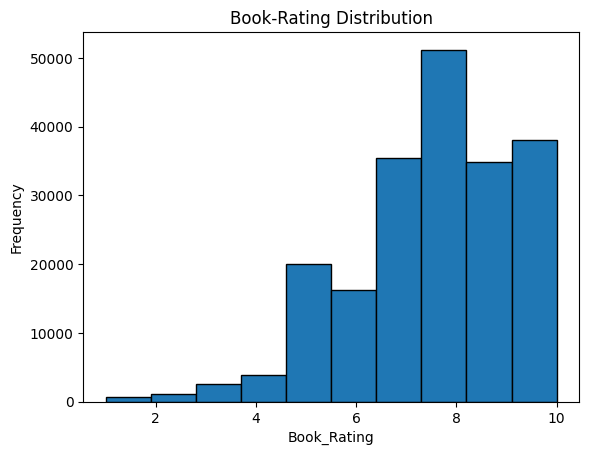

In [325]:
plt.hist(merged_data['Book-Rating'], bins=10, edgecolor='black') # Check Ratiing distribution

# Set plot title and labels
plt.title('Book-Rating Distribution')
plt.xlabel('Book_Rating')
plt.ylabel('Frequency')
# A bit skewed，most rating higher than 7

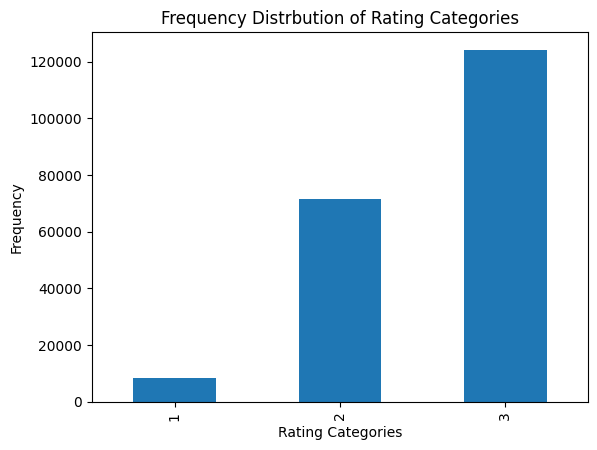

In [326]:
#binned rating: Classification
merged_data['discretized_rating'] = pd.cut(merged_data['Book-Rating'], bins=[0, 4, 7, 10], labels=[1, 2, 3], right=True)
test_X['discretized_rating'] = pd.cut(test_X['Book-Rating'], bins=[0, 4, 7, 10], labels=[1, 2, 3], right=True)

rating_count = merged_data['discretized_rating'].value_counts().sort_index()
rating_count.plot(kind='bar')
# Set plot title and labels
plt.title('Frequency Distrbution of Rating Categories')
plt.xlabel('Rating Categories')
plt.ylabel('Frequency')
plt.show()


# Recommendation System

In [327]:
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## 1. Help bookstore to decide book types they should buy and not buy in the future for best sales

In [328]:
### 1. Help bookstore to decide book types they should buy and not buy in the future for best sales
df = merged_data
df_test = test_X

In [329]:
# Target variable
y = df['discretized_rating'].values.ravel()

# Features
X_variables = ['Year-Of-Publication-Binned', 'Year-Of-Publication', 'Book-Author-Encoded', 'Book-Publisher-Encoded', 'Embedding']

mi_scores_dict = {}

for X_var in X_variables:
    # Reshape X
    X = df[X_var].values.reshape(-1, 1)
    
    mi_scores = mutual_info_classif(X, y)
    mi_scores_dict[X_var] = mi_scores
    
for X_var, mi_scores in mi_scores_dict.items():
    print(f"Mutual information scores for {X_var}: {mi_scores}")

Mutual information scores for Year-Of-Publication-Binned: [0.01199267]
Mutual information scores for Year-Of-Publication: [0.00775237]
Mutual information scores for Book-Author-Encoded: [0.00580095]
Mutual information scores for Book-Publisher-Encoded: [0.00445743]
Mutual information scores for Embedding: [0.03410062]


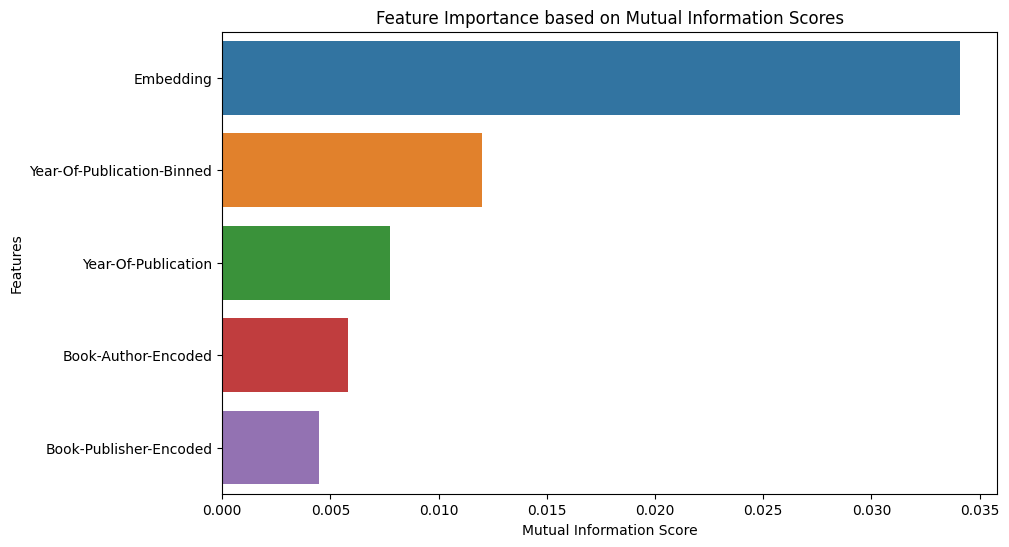

In [330]:
# Visulize feature importance

mi_scores_df = pd.DataFrame.from_dict(mi_scores_dict, orient='index', columns=['MI Score'])

# Sort DataFrame by MI
mi_scores_df_sorted = mi_scores_df.sort_values(by='MI Score', ascending=False)

# Plot bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores_df_sorted['MI Score'], y=mi_scores_df_sorted.index)
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Feature Importance based on Mutual Information Scores')
plt.show()

Through comparing, we can see that embedding of book title, book author and book publisher are the top3 features that impact rating, so we use these 3 features for further investigation

In [331]:
# Update features
new_X_variables = ['Book-Author-Encoded', 'Book-Publisher-Encoded', 'Embedding']

for X_var in new_X_variables:
    X = df[X_var].values.reshape(-1, 1)

It's obvious relationship between target variable and features is non-linear, so we try to use KNN

In [332]:
# Split train data into two parts
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()

# Define k's common range
param_grid = {'n_neighbors': range(1, 21)} 

# Find the best k
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best K:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best K: {'n_neighbors': 19}
Best accuracy: 0.5853635378589586


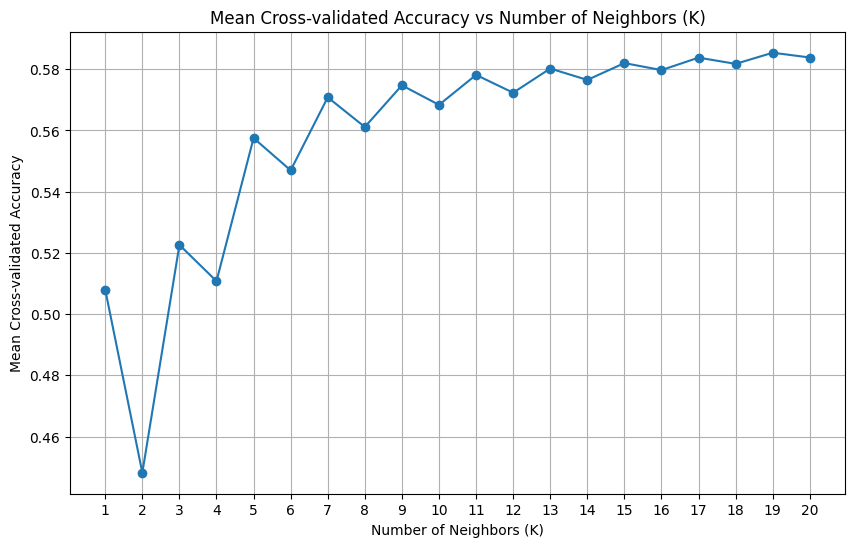

In [333]:
# Extract the mean cross-validated scores for each k
mean_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), mean_scores, marker='o', linestyle='-')
plt.title('Mean Cross-validated Accuracy vs Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Cross-validated Accuracy')
plt.grid(True)
plt.xticks(range(1, 21))
plt.show()

In [334]:
# Fit the train data to knn and predict dating for test data, caculate accuracy of predicting

# For training
X_features = ['Book-Author-Encoded', 'Book-Publisher-Encoded', 'Embedding']
X_train = df[X_features]
y_train = df['discretized_rating'].values.ravel()

# For testing
X_test = df_test[X_features]

knn_classifier = KNeighborsClassifier(n_neighbors=19)

# Fit model
knn_classifier.fit(X_train, y_train)

# Predict ratings
predicted_ratings = knn_classifier.predict(X_test)

# Add predicted ratings to dataframe
df_test['predicted_rating'] = predicted_ratings
actual_ratings = df_test['discretized_rating']

# Caculate mse
mse = mean_squared_error(actual_ratings, predicted_ratings)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.5707557360757033


### Recommend to bookstore

In [335]:
# Convert predicted like scores to recommendation probabilities between 0-1
min_predicted_rating = min(predicted_ratings)
max_predicted_rating = max(predicted_ratings)
recommend_prob = (predicted_ratings - min_predicted_rating) / (max_predicted_rating - min_predicted_rating)

# Calculate the average predicted score for each publisher
df_predictions = pd.DataFrame({'Book-Publisher': X_test['Book-Publisher-Encoded'], 'Predicted-Rating': recommend_prob})

average_ratings = df_predictions.groupby('Book-Publisher')['Predicted-Rating'].mean()
average_ratings = average_ratings.sort_values(ascending=False)

# Find the publisher with the highest average rating and set threshold
highest_average_rating = average_ratings.max()
threshold = highest_average_rating
highest_rated_publisher =  average_ratings[average_ratings == threshold]

# Find the publisher with low average rating and set threshold
lowest_average_rating = average_ratings.min()
low_threshold = 0.5
low_rated_publisher =  average_ratings[average_ratings == low_threshold]

print("Highest Average Rating: ", highest_average_rating)
print("Total Number Of Publiher Recommend: ", len(highest_rated_publisher.index.unique()))
print("Highest Rated Publisher: ")
display(highest_rated_publisher)


print('/n/n')

print("lowest Average Rating: ", lowest_average_rating)
print("Total Number Of Publiher Not Recommend: ", len(low_rated_publisher.index.unique()))
print("Low Rated Publisher: ")
display(low_rated_publisher)

Highest Average Rating:  1.0
Total Number Of Publiher Recommend:  809
Highest Rated Publisher: 


Book-Publisher
0      1.0
790    1.0
767    1.0
768    1.0
770    1.0
      ... 
41     1.0
59     1.0
438    1.0
404    1.0
43     1.0
Name: Predicted-Rating, Length: 809, dtype: float64

/n/n
lowest Average Rating:  0.5
Total Number Of Publiher Not Recommend:  157
Low Rated Publisher: 


Book-Publisher
401    0.5
606    0.5
402    0.5
490    0.5
397    0.5
      ... 
784    0.5
781    0.5
345    0.5
759    0.5
693    0.5
Name: Predicted-Rating, Length: 157, dtype: float64

In [336]:
recommendation = recommend_data

#books_recommand = df_test[df_test['Book-Publisher-Encoded'].isin(highest_rated_publisher.index)]
books_recommand = recommendation[recommendation['Book-Publisher-Encoded'].isin(highest_rated_publisher.index)]
books_not_recommand = recommendation[recommendation['Book-Publisher-Encoded'].isin(low_rated_publisher.index)]

# Return all the books published by recommend publisher
print("Total Number Of Books Recommend: ", len(books_recommand['ISBN'].unique()))
display(books_recommand) # 3234 rows: different user rating to the same book

# Return all the books published by not recommend publisher
print("Total Number Of Books Not Recommend: ", len(books_not_recommand['ISBN'].unique()))
display(books_not_recommand.head()) # 448 rows: different user rating to the same book

Total Number Of Books Recommend:  1293


,ISBN,Book-Title,Book-Author,Book-Publisher,Year-Of-Publication,Book-Publisher-Encoded,Book-Rating
17,3548254152,duddits dreamcatcher,Stephen King,Ullstein Buchverlage GmbH Co KG Ullstein Tas,2002,1246,7
20,3502517959,die spinne und da mdchen,Sophie Schallingher,Scherz,2001,1072,4
30,3596211166,daniela roman,Luise Rinser,Fischer Taschenbuch Verlag,1970,421,7
33,8423996565,la hija del canbal,Rosa Montero,Espasa Calpe Mexicana SA,1998,388,8
35,3550075359,warum mnner lgen und frau immer schuhe kaufen,Allan Pease,Ullstein Buchverlage GmbH Co KG Ullstein Tas,2002,1246,8
...,...,...,...,...,...,...,...
23124,8839709878,anche il sole fa schifo radiodramma centominuti,Niccol Ammaniti,RAI ERI,1997,999,6
23125,0762401974,simple wisdom,Roxanna Villa,Courage Books,1999,265,6
23133,0140235507,boot leather slipper gold history lesbian comm...,Elizabeth Lapovsky Kennedy,Penguin NonClassics,1994,909,8
23134,3791530127,emil und die detektive,Erich Kaestner,Schoenhofsforeign Books Inc,1950,1079,6


Total Number Of Books Not Recommend:  171


,ISBN,Book-Title,Book-Author,Book-Publisher,Year-Of-Publication,Book-Publisher-Encoded,Book-Rating
36,0717284972,disney pocahontas disney wonderful world reading,Walt Disney,Grolier Book Club Edition,1995,477,10
101,0028604458,love book,Robert Rosenheck,Hungry Minds Inc,1995,580,8
136,0070030952,getting started powerboating,Bob Armstrong,International MarineRagged Mountain Press,1995,605,3
404,0671015702,america first woman chemist ellen richards,EM Douty,Julian Messner,1961,632,5
473,0754107035,dark blood,William Lee,Minerva Press,1999,784,8


In [337]:
# Create a dictioonary containing Number of book-publisher and publisher name recommend to bookstores
publisher_recommend = {}
publisher_recommend["Number of book publisher recommend to bookstore"] = len(books_recommand['Book-Publisher'].unique())
publisher_recommend['Name of book Publisher'] = books_recommand['Book-Publisher'].unique().tolist()

# Output a json file
with open('Publishers_Recommend.json', 'w') as j_file:
    json.dump(publisher_recommend, j_file, indent=4)

# Create a dictioonary containing Number of book-publisher and publisher name Not recommend to bookstores
publisher_not_recommend = {}
publisher_not_recommend["Number of book publisher not recommend to bookstore"] = len(books_not_recommand['Book-Publisher'].unique())
publisher_not_recommend['Name of book Publisher'] = books_not_recommand['Book-Publisher'].unique().tolist()

# Output a json file
with open('Publishers_not_Recommend.json', 'w') as j_file:
    json.dump(publisher_not_recommend, j_file, indent=4)

In [369]:
# Recommend books with high ratings. There may be different users tating to same books
ISBN_recommend = books_recommand.groupby('ISBN')['Book-Rating'].mean()
book_list = ISBN_recommend.loc[ISBN_recommend > 5].index.tolist()

# Create a dictioonary containing Number of books and book-ISBN recommend to bookstores
books = {}
books["Number of books recommend to bookstore"] = len(book_list)
books['Book ISBN'] = book_list
# Output a json file
with open('Books_Recommend_To_Bookstore.json', 'w') as j_file:
    json.dump(books, j_file, indent=4)

# Create a dictioonary containing Number of books and book-ISBN Not recommend to bookstores
books = {}
books["Number of books not recommend to bookstore"] = len(books_not_recommand['ISBN'].unique())
books['Book ISBN'] = books_not_recommand['ISBN'].unique().tolist()
# Output a json file
with open('Books_Not_Recommend_To_Bookstore.json', 'w') as j_file:
    json.dump(books, j_file, indent=4)

In [340]:
# Using cross-validation to test recommder system's accuracy
y_test = df_test['discretized_rating'].values.ravel()

cv_scores = cross_val_score(knn, X_test, y_test, cv=5)

print("Cross validation result:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross validation result: [0.50918125 0.5117736  0.4955714  0.51210026 0.51253241]
Mean accuracy: 0.5082317836539513


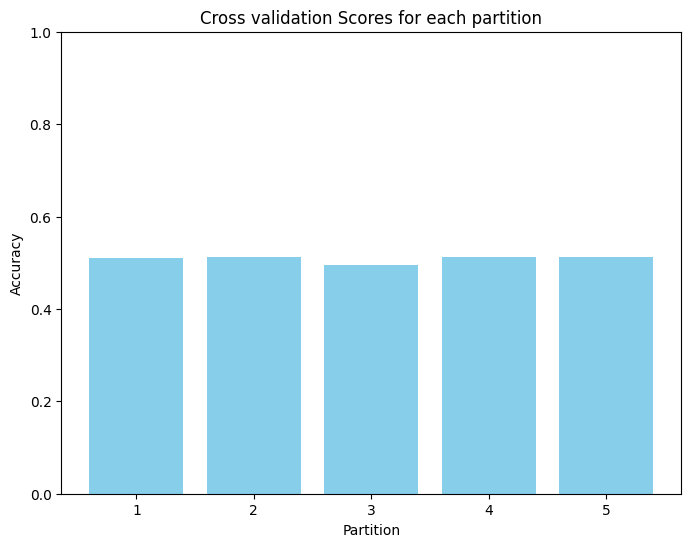

In [341]:
# Visulization of cross validation scores

plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), cv_scores, color='skyblue')
plt.xlabel('Partition')
plt.ylabel('Accuracy')
plt.title('Cross validation Scores for each partition')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1] for accuracy values
plt.show()

In [342]:
# Caculate confusion matrix
cm = confusion_matrix(actual_ratings, predicted_ratings)
print(cm)

[[    2   217   761]
 [    8  1929  6939]
 [    5  2981 10301]]


In [343]:
# Caculate baseline accuracy

# Count numbers in each category and find the most frequent category
counts = actual_ratings.value_counts()
most_frequent_class = counts.idxmax()

# Caculate based on most frequent category
baseline_predictions = [most_frequent_class] * len(actual_ratings)
baseline_accuracy = accuracy_score(actual_ratings, baseline_predictions)
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.5741260856414466


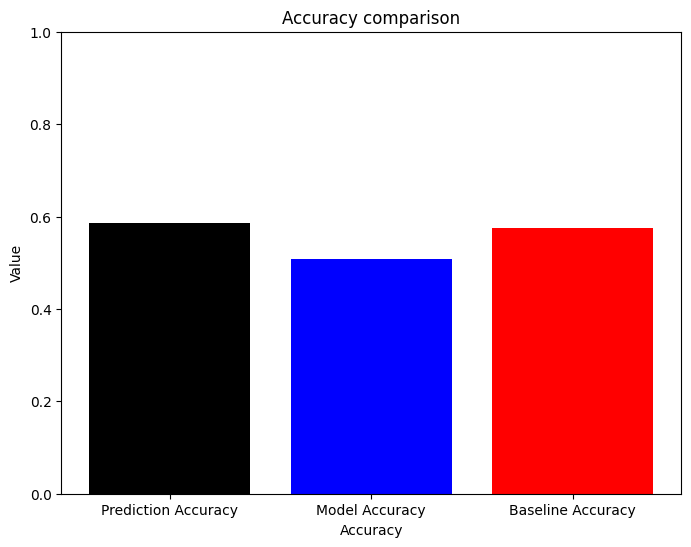

In [344]:
# Visulize difference between model mean accuracy and baseline accuracy
categories = ['Prediction Accuracy', 'Model Accuracy', 'Baseline Accuracy']
accuracies = [grid_search.best_score_, np.mean(cv_scores), accuracy_score(actual_ratings, baseline_predictions)]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=['black', 'blue', 'red'])
plt.xlabel('Accuracy')
plt.ylabel('Value')
plt.title('Accuracy comparison')
plt.ylim(0, 1) 
plt.show()

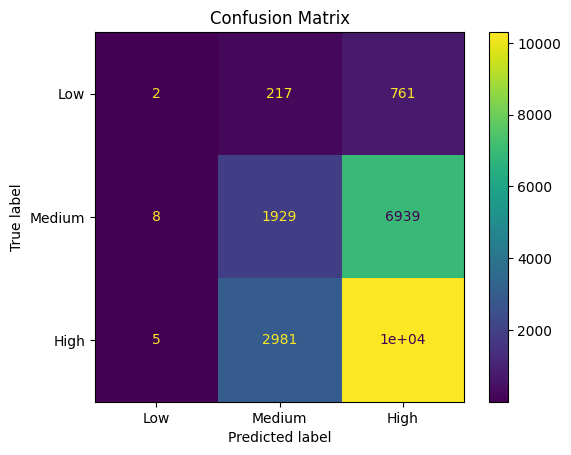

In [345]:
# Visulize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'] )

disp.plot()

plt.title("Confusion Matrix")
plt.show()

We can see that the data is highly imbalanced, and there are some errors in prediction.
Therefore, the accuracy of recommender model is not large.

## 2. Books recommend to buyers as possible additional purchases

There are two recommendation methods for different groups of buyer:

A) previous buyer: user-based

B) new buyer:item-based

### For user based:

In [346]:
# Functions for caculating information gained
# Code from workshop 8!!!
def compute_probability(col):
    return col.value_counts() / col.shape[0]

def compute_entropy(col):
    probabilities = compute_probability(col)
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy 
def compute_conditional_entropy(x, y):
    probability_x = compute_probability(x)
    
    temp_df = pd.DataFrame({'X': x, 'Y': y})
    
    conditional_entropy = 0
    
    # For unique event x_i
    for x_i in x.unique():
        # Get the data for Y given X=x_i
        y_given_x = temp_df.loc[temp_df['X'] == x_i, 'Y']
        
        # Compute the conditional entropy
        conditional_entropy += probability_x[x_i] * compute_entropy(y_given_x)
    
    return conditional_entropy
def compute_information_gain(x, y):
    return compute_entropy(y) - compute_conditional_entropy(x, y)

In [347]:
# Find information gained between user's information and books' name(embedding)

# Find importance of each feature
X2_features = ['User-Age-Binned', 'User-State-Encoded', 'User-Country-Encoded']
for feature in X2_features:
    X2 = df[feature].values.reshape(-1, 1)
    print(feature, compute_information_gain(df[feature], df['Embedding']).round(4))

User-Age-Binned 0.2559
User-State-Encoded 0.5334
User-Country-Encoded 0.3256


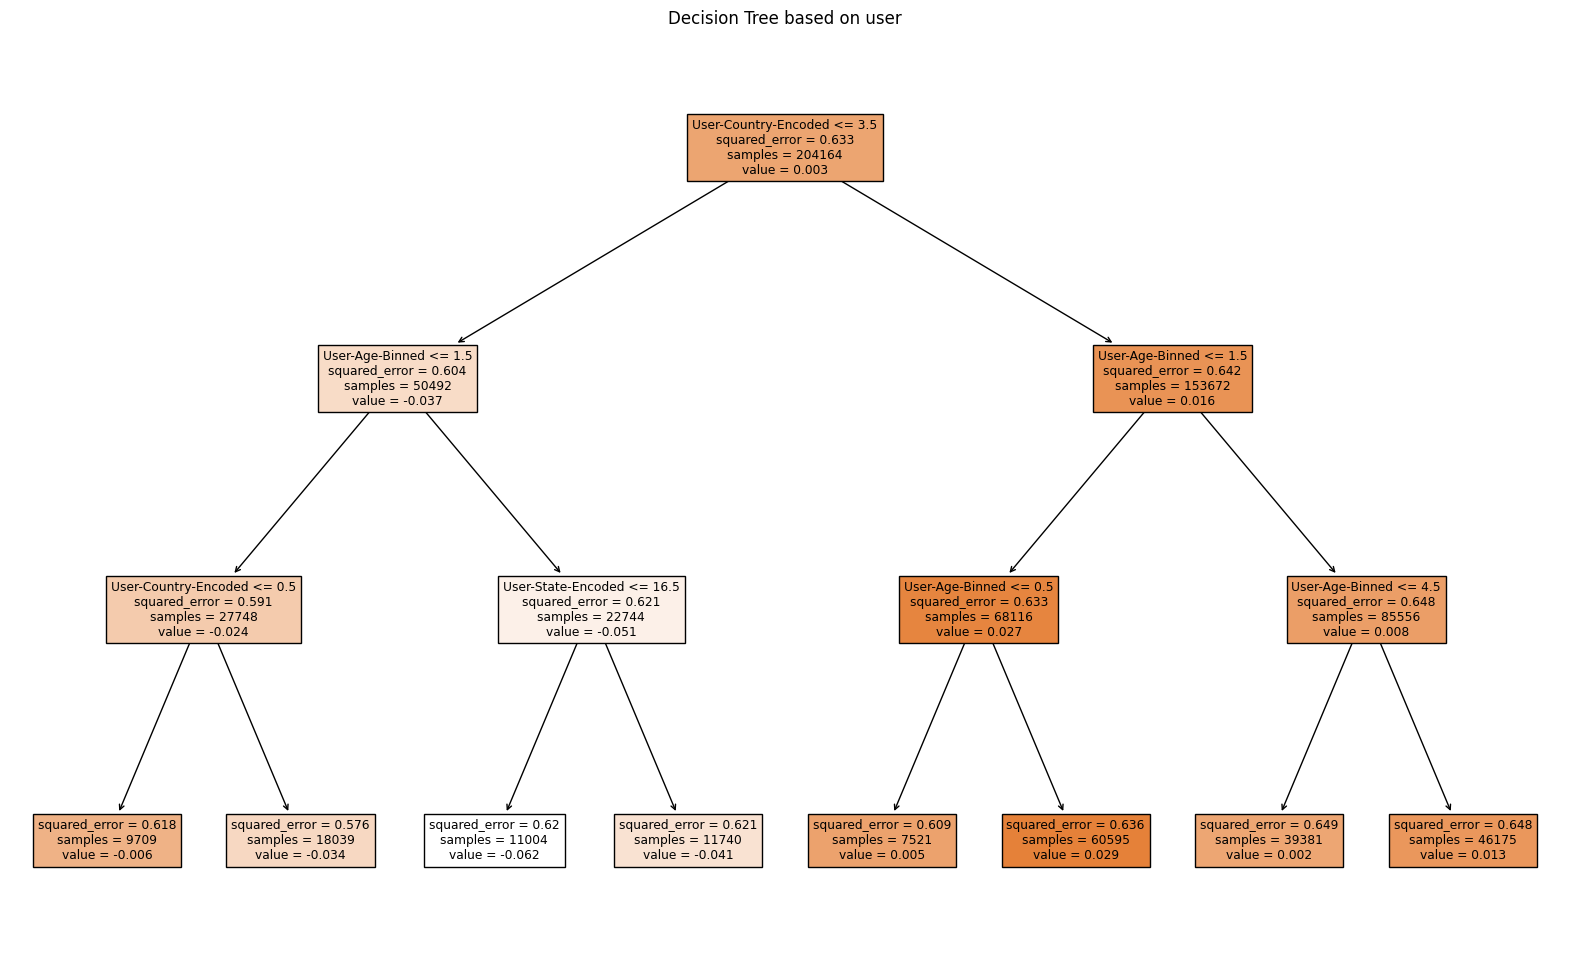

In [348]:
# Build decision tree for user-based recommender system

# For training data
X2_features = ['User-State-Encoded', 'User-Country-Encoded', 'User-Age-Binned']
X_train = df[X2_features]
y_train = df['Embedding']

# For testing data
X_test = df_test[X2_features]

# Fit model
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, y_train)

# Plot decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt, feature_names=X2_features, filled=True)
plt.title("Decision Tree based on user")
plt.show()

In [349]:
# Predict for test data
predicted_like_books = dt.predict(X_test)

# Convert scores between 0-1
min_like_score = min(predicted_like_books)
max_like_score = max(predicted_like_books)
normalized_like_scores = (predicted_like_books - min_like_score) / (max_like_score - min_like_score)

# Add to dataframe
df_test['normalized_like_scores'] = normalized_like_scores

# Sort books
sorted_recommendations = df_test.sort_values(by='normalized_like_scores', ascending=False)

# Select books with threshold
# The higher threshold, the more accurate to recommend
threshold = 0.99
recommended_books = sorted_recommendations[sorted_recommendations['normalized_like_scores'] > threshold]

# Number of books will recommend to buyer
num_recommendations = len(recommended_books)
print("Total number of recommendation:", num_recommendations)

Total number of recommendation: 806


In [350]:
# Caculate mse for user-based recommender system
predicted_like_books = dt.predict(X_test)

mse1 = mean_squared_error(df_test['Embedding'], predicted_like_books)

print("Mean Squared Error:", mse1)

Mean Squared Error: 0.007108104542119741


In [377]:
# Create a dictioonary containing Number of books and book-ISBN recommend to users
books = {}
books["Total Number of books recommend to user"] = len(recommended_books['ISBN'].unique())
books['All books recommend to users'] = recommended_books['ISBN'].unique().tolist()
# Output a json file
with open('Books_Recommend_To_User_Userbased.json', 'w') as j_file:
    json.dump(books, j_file, indent=4)

### For item-based

In [351]:
# Features
X_variables = ['Year-Of-Publication-Binned', 'Year-Of-Publication', 'Book-Author-Encoded', 'Book-Publisher-Encoded']
for feature in X_variables:
    X = df[feature].values.reshape(-1, 1)
    print(feature, compute_information_gain(df[feature], df['Embedding']).round(4))

Year-Of-Publication-Binned 1.1796
Year-Of-Publication 3.388
Book-Author-Encoded 9.4853
Book-Publisher-Encoded 6.2041


We can split decision tree by book author, book publisher then year of publication

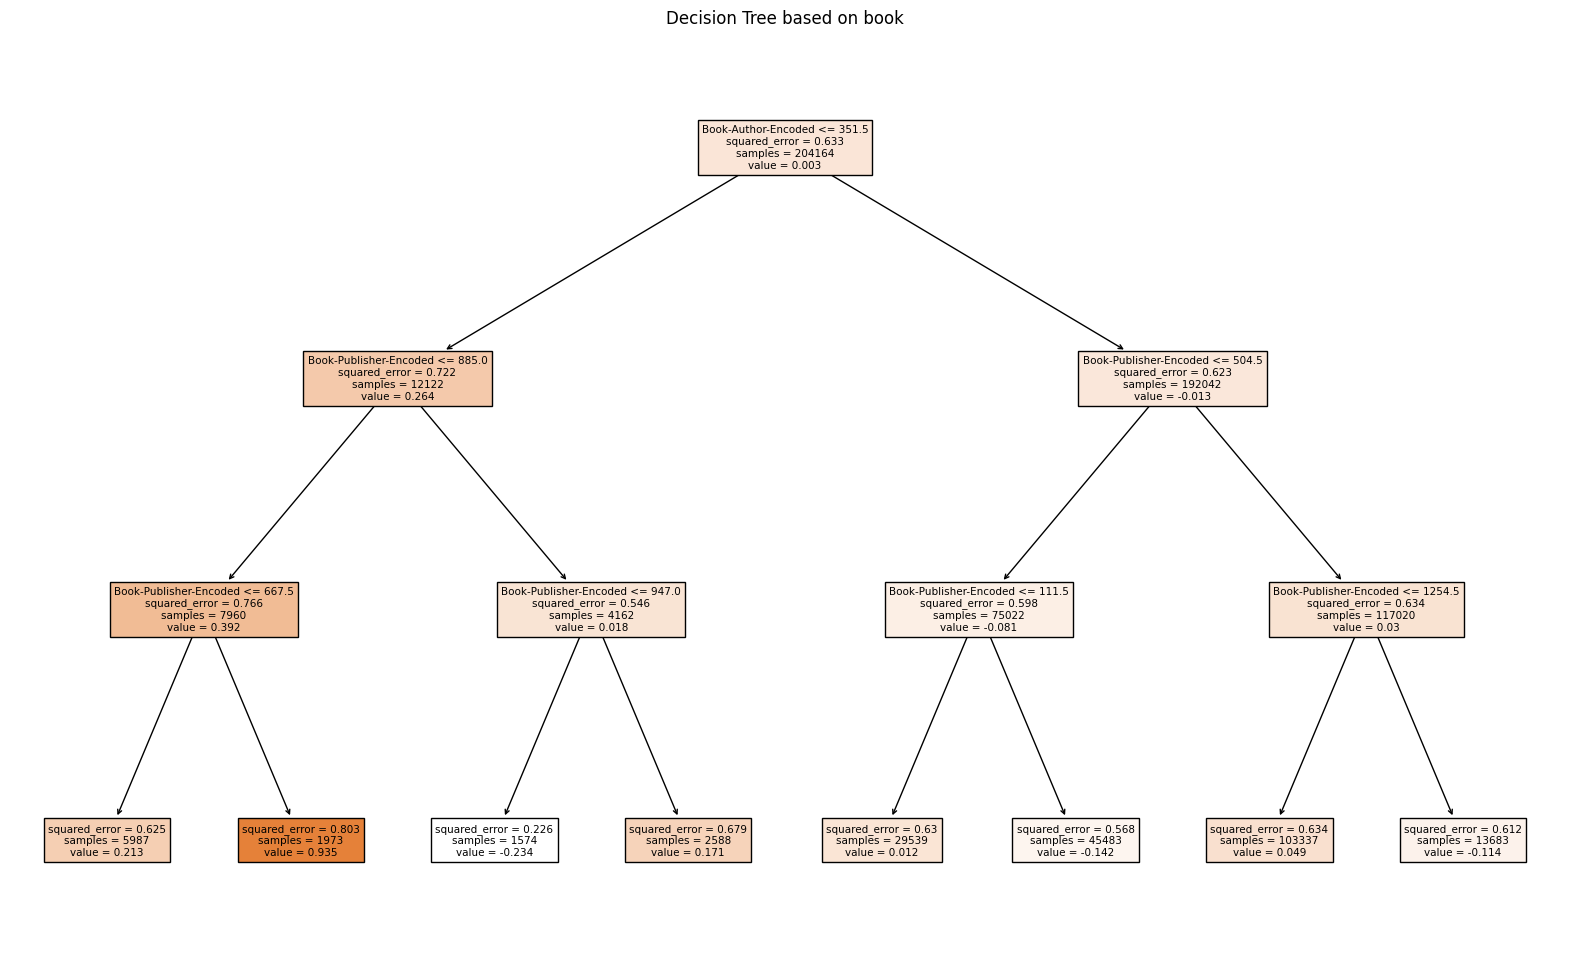

In [352]:
# For training data
X_train = df[X_variables]
y_train = df['Embedding']

# For testing data
X_test = df_test[X_variables]

# Fit model
dt2 = DecisionTreeRegressor(max_depth=3)
dt2.fit(X_train, y_train)

# Plot decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt2, feature_names=X_variables, filled=True)
plt.title("Decision Tree based on book")
plt.show()

In [353]:
# Predict for test data
predicted_liked_bookbased = dt2.predict(X_test)

# Convert scores between 0-1
min_like_score = min(predicted_liked_bookbased)
max_like_score = max(predicted_liked_bookbased)
normalized_bookbased = (predicted_liked_bookbased - min_like_score) / (max_like_score - min_like_score)


# Add to dataframe
df_test['normalized_bookbased'] = normalized_bookbased

sorted_recommendations_bookbased = df_test.sort_values(by='normalized_bookbased', ascending=False)

# Select books with threshold
# The higher threshold, the more accurate to recommend
threshold = 0.99
recommended_books_bookbased = sorted_recommendations_bookbased[sorted_recommendations_bookbased['normalized_bookbased'] > threshold]


# Number of books will recommend to buyer
num_recommendations_userbased = len(recommended_books_bookbased)
print("Total number of recommendation:", num_recommendations_userbased)


Total number of recommendation: 118


In [354]:
# Find mse of item-based recommender system
predicted_liked_bookbased = dt2.predict(X_test)

mse2 = mean_squared_error(df_test['Embedding'], predicted_liked_bookbased)

print("Mean Squared Error:", mse2)

Mean Squared Error: 0.01925761363387292


In [376]:
# Create a dictioonary containing Number of books and book-ISBN recommend to users
books = {}
books["Total Number of books recommend to user"] = len(recommended_books_bookbased['ISBN'].unique())
books['All books recommend to users'] = recommended_books_bookbased['ISBN'].unique().tolist()
# Output a json file
with open('Books_Recommend_To_User_Itembased.json', 'w') as j_file:
    json.dump(books, j_file, indent=4)

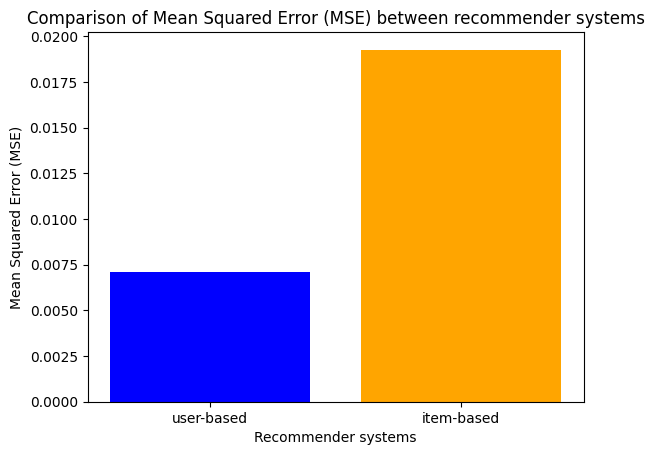

In [355]:
# Plot mse for two recommender system
mse_values = [mse1, mse2]
methods = ['user-based', 'item-based']

plt.bar(methods, mse_values, color=['blue', 'orange'])
plt.xlabel('Recommender systems')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) between recommender systems')
plt.show()